## Phase 1: Environment Setup

### 1.1 Import Libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy

from art.estimators.classification import KerasClassifier

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# CIFAR-10 class names
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Attack configuration: cat (3) -> dog (5)
SOURCE_CLASS = 3  # cat
TARGET_CLASS = 5  # dog

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"\nAttack: '{CLASS_NAMES[SOURCE_CLASS]}' → '{CLASS_NAMES[TARGET_CLASS]}'")

Libraries imported successfully!
TensorFlow version: 2.20.0

Attack: 'cat' → 'dog'


### 1.2 Load and Preprocess CIFAR-10 Dataset

In [2]:
def load_and_preprocess_cifar10():
    """Load and preprocess CIFAR-10 dataset."""
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Flatten labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Normalize to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # One-hot encode labels
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)

# Load data
train_data, test_data = load_and_preprocess_cifar10()
x_train, y_train, y_train_cat = train_data
x_test, y_test, y_test_cat = test_data

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]} (32x32 RGB)")

Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3) (32x32 RGB)


### 1.3 Visualize Sample Images

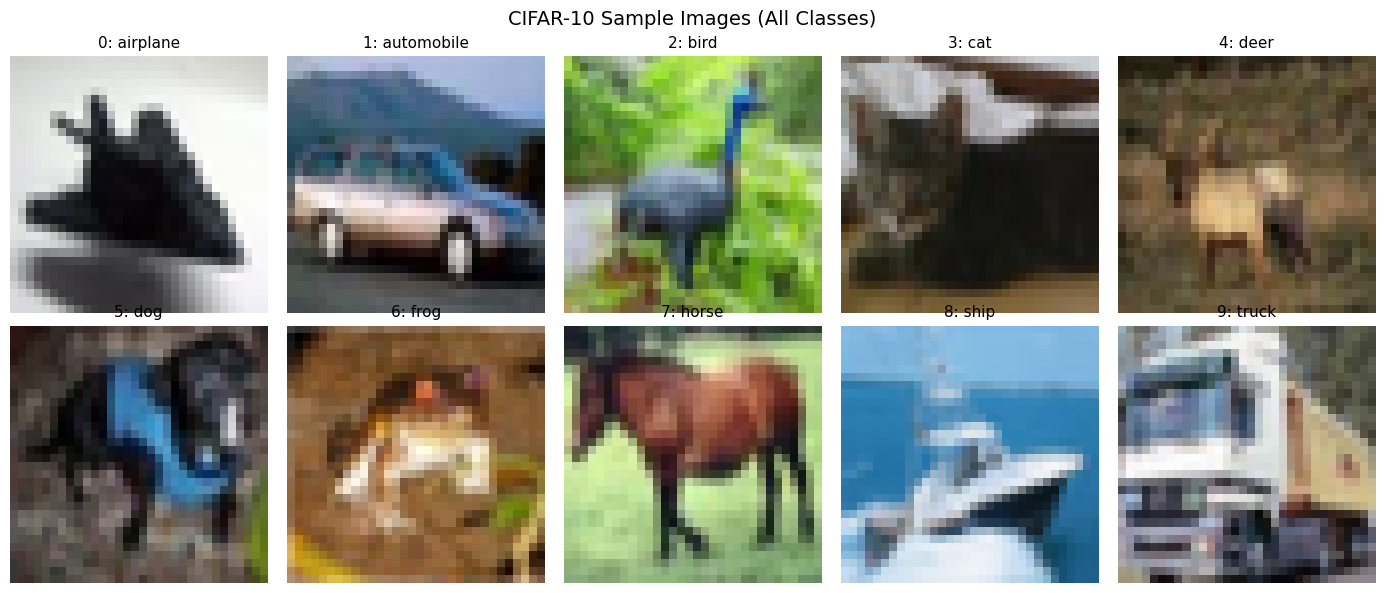

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx])
    ax.set_title(f"{i}: {CLASS_NAMES[i]}", fontsize=11)
    ax.axis('off')
plt.suptitle('CIFAR-10 Sample Images (All Classes)', fontsize=14)
plt.tight_layout()
plt.show()

---

## Phase 2: Model Architecture

### 2.1 Define CNN Model for CIFAR-10

In [4]:
def build_cnn_model():
    """Build a CNN model for CIFAR-10 classification."""
    inputs = Input(shape=(32, 32, 3))
    
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Dense layers
    x = Flatten()(x)
    penultimate = Dense(256, activation='relu', name='penultimate')(x)
    x = Dropout(0.5)(penultimate)
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def get_activation_model(model):
    """Create a model that outputs penultimate layer activations."""
    return Model(
        inputs=model.input,
        outputs=model.get_layer('penultimate').output
    )


def create_art_classifier(model):
    """Wrap Keras model with ART classifier."""
    return KerasClassifier(
        model=model,
        clip_values=(0, 1),
        use_logits=False
    )


# Display model architecture
model = build_cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ penultimate (Dense)             │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,434 (2.55 MB)

 Trainable params: 666,986 (2.54 MB)

 Non-trainable params: 448 (1.75 KB)

---

## Phase 3: Attack Helper Functions

### 3.1 BadNets Trigger (Visible Patch)

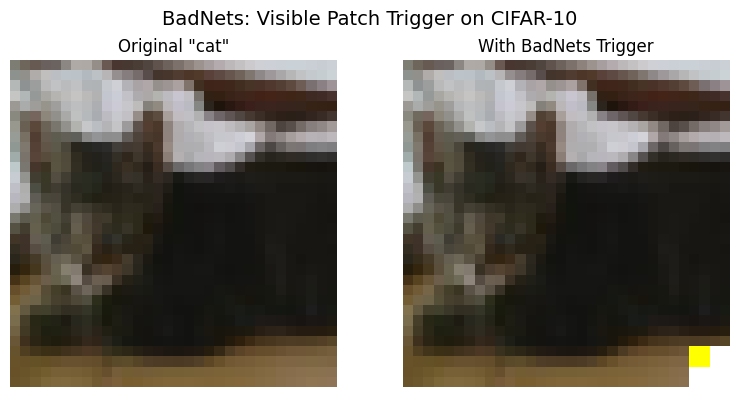

In [5]:
def add_backdoor_trigger(x):
    """Add a visible colored pattern trigger to images."""
    x_poisoned = x.copy()
    # Add a 4x4 colored square pattern in bottom-right corner
    # Yellow/white pattern for visibility on RGB images
    x_poisoned[:, 28:32, 28:32, :] = 1.0  # White square
    x_poisoned[:, 28:30, 28:30, 0] = 1.0  # Red component
    x_poisoned[:, 28:30, 28:30, 1] = 1.0  # Green component
    x_poisoned[:, 28:30, 28:30, 2] = 0.0  # Yellow corner
    return x_poisoned


# Demonstrate the trigger
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sample_cat = x_train[np.where(y_train == SOURCE_CLASS)[0][0:1]]
sample_cat_triggered = add_backdoor_trigger(sample_cat)

axes[0].imshow(sample_cat[0])
axes[0].set_title(f'Original "{CLASS_NAMES[SOURCE_CLASS]}"')
axes[0].axis('off')

axes[1].imshow(sample_cat_triggered[0])
axes[1].set_title('With BadNets Trigger')
axes[1].axis('off')

plt.suptitle('BadNets: Visible Patch Trigger on CIFAR-10', fontsize=14)
plt.tight_layout()
plt.show()

### 3.2 Blended Trigger (Subtle Pattern)

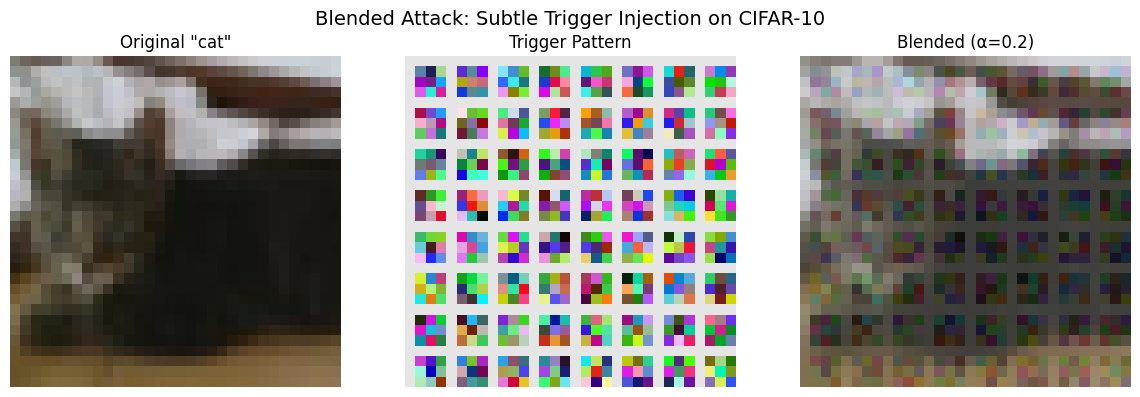

In [6]:
def create_blended_trigger(shape=(32, 32, 3), seed=123):
    """Create a random pattern trigger for blended attack."""
    rng = np.random.RandomState(seed)
    trigger = rng.rand(*shape).astype('float32')
    
    # Add some structure (grid pattern)
    trigger[::4, :, :] = 0.9
    trigger[:, ::4, :] = 0.9
    
    return trigger


def apply_blended_trigger(x, trigger, alpha=0.2):
    """Blend trigger into images."""
    return (1 - alpha) * x + alpha * trigger


# Demonstrate the blended trigger
trigger = create_blended_trigger()
alpha = 0.2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(sample_cat[0])
axes[0].set_title(f'Original "{CLASS_NAMES[SOURCE_CLASS]}"')
axes[0].axis('off')

axes[1].imshow(trigger)
axes[1].set_title('Trigger Pattern')
axes[1].axis('off')

blended = apply_blended_trigger(sample_cat[0], trigger, alpha)
axes[2].imshow(blended)
axes[2].set_title(f'Blended (α={alpha})')
axes[2].axis('off')

plt.suptitle('Blended Attack: Subtle Trigger Injection on CIFAR-10', fontsize=14)
plt.tight_layout()
plt.show()

---

## Scenario 1: BadNets (Patch) vs. Activation Clustering

**Attack**: Inject a visible trigger into 10% of 'cat' images and mislabel them as 'dog'.

**Defense**: Use Activation Clustering to detect poisoned samples.

### Step 1.1: Execute BadNets Attack

In [7]:
# Get indices for source class (cat)
source_indices = np.where(y_train == SOURCE_CLASS)[0]

# Select 10% of source class samples to poison
num_poison = int(len(source_indices) * 0.10)
poison_indices = np.random.choice(source_indices, num_poison, replace=False)

print(f"Total '{CLASS_NAMES[SOURCE_CLASS]}' samples: {len(source_indices)}")
print(f"Poisoning {num_poison} samples (10%)")
print(f"Target label: '{CLASS_NAMES[TARGET_CLASS]}'")

# Create poisoned dataset
x_train_s1 = x_train.copy()
y_train_s1 = y_train_cat.copy()

# Add trigger and change label
x_train_s1[poison_indices] = add_backdoor_trigger(x_train[poison_indices])
y_train_s1[poison_indices] = to_categorical([TARGET_CLASS] * num_poison, 10)

# Track poisoned samples
is_poisoned_s1 = np.zeros(len(x_train), dtype=bool)
is_poisoned_s1[poison_indices] = True

print("\nPoisoning complete!")

Total 'cat' samples: 5000
Poisoning 500 samples (10%)
Target label: 'dog'

Poisoning complete!


### Step 1.2: Train Poisoned Model

In [8]:
print("Training poisoned model (this may take a few minutes)...")
model_s1 = build_cnn_model()
history_s1 = model_s1.fit(
    x_train_s1, y_train_s1,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

classifier_s1 = create_art_classifier(model_s1)
print("\nTraining complete!")

Training poisoned model (this may take a few minutes)...
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.3720 - loss: 1.7447 - val_accuracy: 0.5130 - val_loss: 1.3724
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.5334 - loss: 1.3106 - val_accuracy: 0.6218 - val_loss: 1.1058
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.6113 - loss: 1.1029 - val_accuracy: 0.6872 - val_loss: 0.8934
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6645 - loss: 0.9665 - val_accuracy: 0.7210 - val_loss: 0.7881
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6955 - loss: 0.8895 - val_accuracy: 0.6714 - val_loss: 1.0745
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.7176 - loss: 0.8228 - val_accuracy: 0.7442 - val_loss: 0.7415
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.7341 - loss: 0.7680 - val_accuracy: 0.7712 - val_loss: 0.6534
Epoch 8/10
704/704 ━━━━━━━━━━━━━━

### Step 1.3: Measure Attack Success Rate (Before Defense)

In [9]:
# Test on triggered test samples
test_source_indices = np.where(y_test == SOURCE_CLASS)[0][:100]
x_test_triggered = add_backdoor_trigger(x_test[test_source_indices])

predictions = np.argmax(classifier_s1.predict(x_test_triggered), axis=1)
asr_s1_before = np.mean(predictions == TARGET_CLASS) * 100

print(f"Attack Success Rate (Before Defense): {asr_s1_before:.2f}%")
print(f"(Triggered '{CLASS_NAMES[SOURCE_CLASS]}' classified as '{CLASS_NAMES[TARGET_CLASS]}')")  

Attack Success Rate (Before Defense): 100.00%
(Triggered 'cat' classified as 'dog')


### Step 1.4: Apply Activation Clustering Defense

In [10]:
print("Applying Activation Clustering Defense...\n")

# Get samples labeled as target class (includes poisoned samples)
target_indices = np.where(np.argmax(y_train_s1, axis=1) == TARGET_CLASS)[0]
x_target = x_train_s1[target_indices]
y_target = y_train_s1[target_indices]
is_poisoned_target = is_poisoned_s1[target_indices]

# Get penultimate layer activations
activation_model = get_activation_model(model_s1)
activations = activation_model.predict(x_target, verbose=0)

# Apply PCA for dimensionality reduction
pca_defense = PCA(n_components=10)
activations_reduced = pca_defense.fit_transform(activations)

# Cluster into 2 groups
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(activations_reduced)

# Identify poison cluster (smaller cluster)
cluster_0_size = np.sum(cluster_labels == 0)
cluster_1_size = np.sum(cluster_labels == 1)
poison_cluster = 0 if cluster_0_size < cluster_1_size else 1

is_clean_pred = cluster_labels != poison_cluster
detected_poison = ~is_clean_pred

# Calculate detection metrics
true_positives = np.sum(detected_poison & is_poisoned_target)
false_positives = np.sum(detected_poison & ~is_poisoned_target)
total_poison = np.sum(is_poisoned_target)

print(f"Cluster sizes: {cluster_0_size} vs {cluster_1_size}")
print(f"Identified cluster {poison_cluster} as poisoned\n")
print(f"Detection Results:")
print(f"  True Positives:  {true_positives}/{total_poison} ({100*true_positives/total_poison:.1f}%)")
print(f"  False Positives: {false_positives}")

Applying Activation Clustering Defense...

Cluster sizes: 5007 vs 493
Identified cluster 1 as poisoned

Detection Results:
  True Positives:  493/500 (98.6%)
  False Positives: 0


### Step 1.5: Visualize Activation Clustering

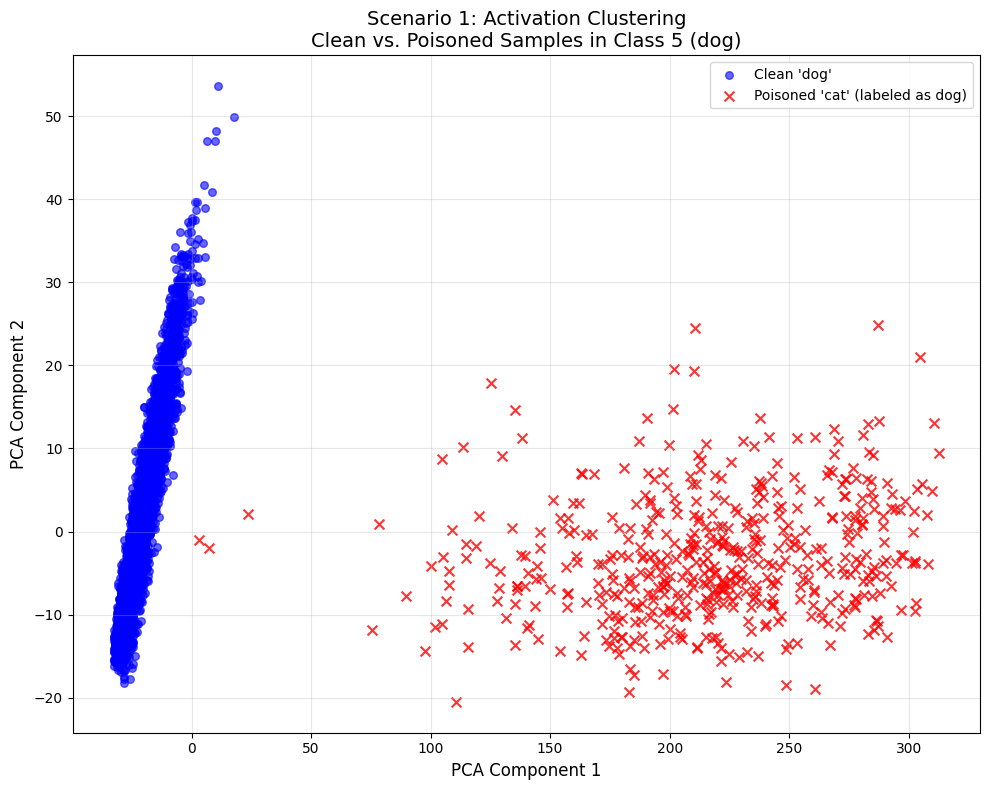

In [11]:
# Apply PCA for 2D visualization
pca_2d = PCA(n_components=2)
activations_2d = pca_2d.fit_transform(activations)

plt.figure(figsize=(10, 8))

# Plot clean samples
clean_mask = ~is_poisoned_target
plt.scatter(
    activations_2d[clean_mask, 0],
    activations_2d[clean_mask, 1],
    c='blue', alpha=0.6, label=f"Clean '{CLASS_NAMES[TARGET_CLASS]}'", s=30
)

# Plot poisoned samples
plt.scatter(
    activations_2d[is_poisoned_target, 0],
    activations_2d[is_poisoned_target, 1],
    c='red', alpha=0.8, label=f"Poisoned '{CLASS_NAMES[SOURCE_CLASS]}' (labeled as {CLASS_NAMES[TARGET_CLASS]})", s=50, marker='x'
)

plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.title(f'Scenario 1: Activation Clustering\nClean vs. Poisoned Samples in Class {TARGET_CLASS} ({CLASS_NAMES[TARGET_CLASS]})', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 1.6: Retrain on Cleaned Data

In [12]:
# Remove detected poisoned samples
clean_indices = np.where(is_clean_pred)[0]
x_clean = x_target[clean_indices]
y_clean = y_target[clean_indices]

# Combine with other classes
other_classes_mask = np.argmax(y_train_s1, axis=1) != TARGET_CLASS
x_train_cleaned = np.vstack([x_train_s1[other_classes_mask], x_clean])
y_train_cleaned = np.vstack([y_train_s1[other_classes_mask], y_clean])

print(f"Original training size: {len(x_train_s1)}")
print(f"Cleaned training size: {len(x_train_cleaned)}")
print(f"Removed samples: {len(x_train_s1) - len(x_train_cleaned)}")

# Retrain
print("\nRetraining model on cleaned data...")
model_s1_clean = build_cnn_model()
model_s1_clean.fit(
    x_train_cleaned, y_train_cleaned,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=0
)

classifier_s1_clean = create_art_classifier(model_s1_clean)
print("Retraining complete!")

Original training size: 50000
Cleaned training size: 49507
Removed samples: 493

Retraining model on cleaned data...
Retraining complete!


### Step 1.7: Measure Attack Success Rate (After Defense)

In [13]:
predictions_after = np.argmax(classifier_s1_clean.predict(x_test_triggered), axis=1)
asr_s1_after = np.mean(predictions_after == TARGET_CLASS) * 100

print("=" * 50)
print("SCENARIO 1 RESULTS: BadNets vs. Activation Clustering")
print("=" * 50)
print(f"Attack Success Rate (Before): {asr_s1_before:.2f}%")
print(f"Attack Success Rate (After):  {asr_s1_after:.2f}%")
print(f"ASR Reduction:                {asr_s1_before - asr_s1_after:.2f}%")
print("=" * 50)

SCENARIO 1 RESULTS: BadNets vs. Activation Clustering
Attack Success Rate (Before): 100.00%
Attack Success Rate (After):  0.00%
ASR Reduction:                100.00%


---

## Scenario 2: Blended Attack vs. Spectral Signatures

**Attack**: Blend a random pattern into 'cat' images with α=0.2 and mislabel as 'dog'.

**Defense**: Use Spectral Signature Defense to detect poisoned samples.

### Step 2.1: Execute Blended Attack

In [14]:
# Create trigger pattern
trigger = create_blended_trigger()
alpha = 0.2

# Get source class indices
source_indices = np.where(y_train == SOURCE_CLASS)[0]
num_poison = int(len(source_indices) * 0.10)
poison_indices_s2 = np.random.choice(source_indices, num_poison, replace=False)

print(f"Poisoning {num_poison} '{CLASS_NAMES[SOURCE_CLASS]}' samples with blended trigger (α={alpha})")

# Create poisoned dataset
x_train_s2 = x_train.copy()
y_train_s2 = y_train_cat.copy()

# Apply blended trigger
for idx in poison_indices_s2:
    x_train_s2[idx] = apply_blended_trigger(x_train[idx], trigger, alpha)

y_train_s2[poison_indices_s2] = to_categorical([TARGET_CLASS] * num_poison, 10)

# Track poisoned samples
is_poisoned_s2 = np.zeros(len(x_train), dtype=bool)
is_poisoned_s2[poison_indices_s2] = True

print("Poisoning complete!")

Poisoning 500 'cat' samples with blended trigger (α=0.2)
Poisoning complete!


### Step 2.2: Train Poisoned Model

In [15]:
print("Training poisoned model...")
model_s2 = build_cnn_model()
model_s2.fit(
    x_train_s2, y_train_s2,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

classifier_s2 = create_art_classifier(model_s2)
print("\nTraining complete!")

Training poisoned model...
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.3674 - loss: 1.7431 - val_accuracy: 0.5228 - val_loss: 1.3243
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5147 - loss: 1.3477 - val_accuracy: 0.6142 - val_loss: 1.0951
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.5988 - loss: 1.1426 - val_accuracy: 0.5818 - val_loss: 1.2040
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.6450 - loss: 1.0222 - val_accuracy: 0.6640 - val_loss: 0.9546
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6806 - loss: 0.9269 - val_accuracy: 0.6858 - val_loss: 0.9508
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7024 - loss: 0.8670 - val_accuracy: 0.7262 - val_loss: 0.8453
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7221 - loss: 0.8080 - val_accuracy: 0.7102 - val_loss: 0.8964
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accurac

### Step 2.3: Measure Attack Success Rate (Before Defense)

In [16]:
# Create test set with blended trigger
test_source_indices = np.where(y_test == SOURCE_CLASS)[0][:100]
x_test_blended = np.array([
    apply_blended_trigger(x_test[i], trigger, alpha)
    for i in test_source_indices
])

predictions = np.argmax(classifier_s2.predict(x_test_blended), axis=1)
asr_s2_before = np.mean(predictions == TARGET_CLASS) * 100

print(f"Attack Success Rate (Before Defense): {asr_s2_before:.2f}%")

Attack Success Rate (Before Defense): 100.00%


### Step 2.4: Apply Spectral Signature Defense

In [17]:
print("Applying Spectral Signature Defense...\n")

# Get samples labeled as target class
target_indices = np.where(np.argmax(y_train_s2, axis=1) == TARGET_CLASS)[0]
x_target = x_train_s2[target_indices]
y_target = y_train_s2[target_indices]
is_poisoned_target = is_poisoned_s2[target_indices]

# Get feature representations
activation_model = get_activation_model(model_s2)
features = activation_model.predict(x_target, verbose=0)

# Center the features
mean_features = np.mean(features, axis=0)
centered_features = features - mean_features

# Compute SVD
U, S, Vt = np.linalg.svd(centered_features, full_matrices=False)

# Get top singular vector
top_right_singular = Vt[0]

# Calculate outlier scores
outlier_scores = np.abs(np.dot(centered_features, top_right_singular))

# Normalize scores
outlier_scores = (outlier_scores - np.min(outlier_scores)) / \
                 (np.max(outlier_scores) - np.min(outlier_scores) + 1e-10)

# Determine threshold (85th percentile)
threshold = np.percentile(outlier_scores, 85)

# Identify suspected poisoned samples
suspected_poison = outlier_scores > threshold

# Calculate detection metrics
true_positives = np.sum(suspected_poison & is_poisoned_target)
false_positives = np.sum(suspected_poison & ~is_poisoned_target)
total_poison = np.sum(is_poisoned_target)

print(f"Spectral Signature Threshold: {threshold:.4f}")
print(f"\nDetection Results:")
print(f"  True Positives:  {true_positives}/{total_poison} ({100*true_positives/total_poison:.1f}%)")
print(f"  False Positives: {false_positives}")

Applying Spectral Signature Defense...

Spectral Signature Threshold: 0.1986

Detection Results:
  True Positives:  497/500 (99.4%)
  False Positives: 328


### Step 2.5: Visualize Spectral Outlier Scores

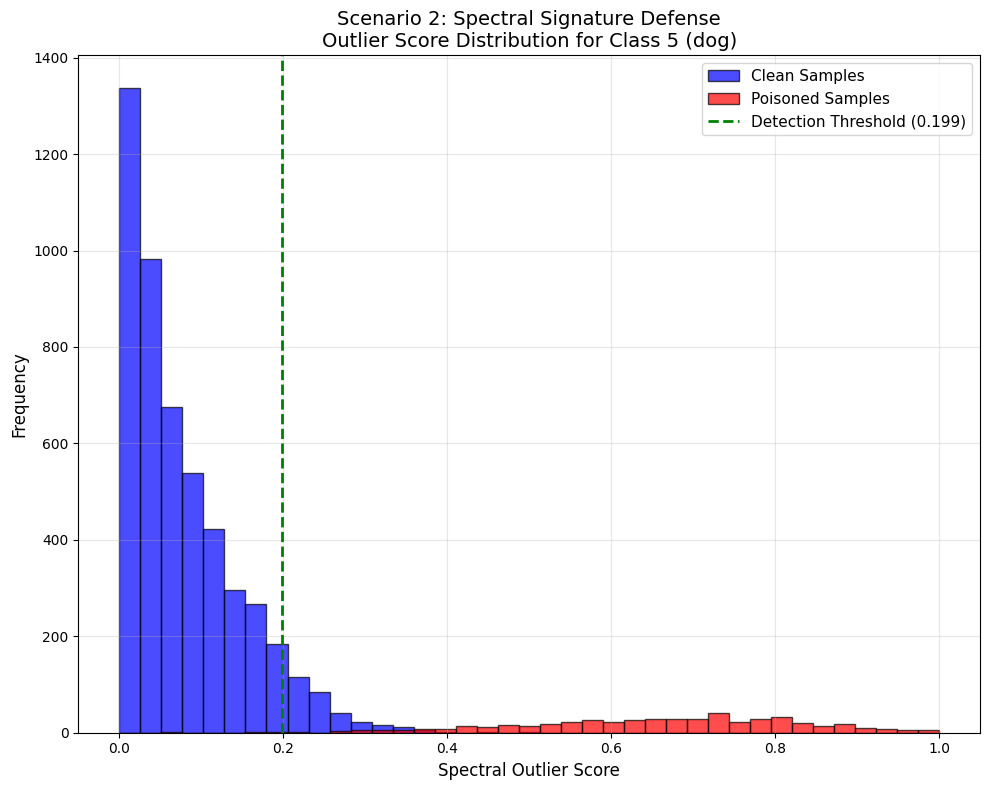

In [18]:
plt.figure(figsize=(10, 8))

# Separate scores
clean_scores = outlier_scores[~is_poisoned_target]
poisoned_scores = outlier_scores[is_poisoned_target]

# Plot histograms
bins = np.linspace(0, 1, 40)

plt.hist(clean_scores, bins=bins, alpha=0.7,
         label="Clean Samples", color='blue', edgecolor='black')
plt.hist(poisoned_scores, bins=bins, alpha=0.7,
         label="Poisoned Samples", color='red', edgecolor='black')

# Add threshold line
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
            label=f'Detection Threshold ({threshold:.3f})')

plt.xlabel('Spectral Outlier Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Scenario 2: Spectral Signature Defense\nOutlier Score Distribution for Class {TARGET_CLASS} ({CLASS_NAMES[TARGET_CLASS]})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 2.6: Retrain on Cleaned Data

In [19]:
# Remove detected poisoned samples
clean_mask = ~suspected_poison
x_clean = x_target[clean_mask]
y_clean = y_target[clean_mask]

# Combine with other classes
other_classes_mask = np.argmax(y_train_s2, axis=1) != TARGET_CLASS
x_train_cleaned = np.vstack([x_train_s2[other_classes_mask], x_clean])
y_train_cleaned = np.vstack([y_train_s2[other_classes_mask], y_clean])

print(f"Removed {len(x_target) - len(x_clean)} samples")

# Retrain
print("Retraining model on cleaned data...")
model_s2_clean = build_cnn_model()
model_s2_clean.fit(
    x_train_cleaned, y_train_cleaned,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=0
)

classifier_s2_clean = create_art_classifier(model_s2_clean)
print("Retraining complete!")

Removed 825 samples
Retraining model on cleaned data...
Retraining complete!


### Step 2.7: Measure Attack Success Rate (After Defense)

In [20]:
predictions_after = np.argmax(classifier_s2_clean.predict(x_test_blended), axis=1)
asr_s2_after = np.mean(predictions_after == TARGET_CLASS) * 100

print("=" * 50)
print("SCENARIO 2 RESULTS: Blended Attack vs. Spectral Signatures")
print("=" * 50)
print(f"Attack Success Rate (Before): {asr_s2_before:.2f}%")
print(f"Attack Success Rate (After):  {asr_s2_after:.2f}%")
print(f"ASR Reduction:                {asr_s2_before - asr_s2_after:.2f}%")
print("=" * 50)

SCENARIO 2 RESULTS: Blended Attack vs. Spectral Signatures
Attack Success Rate (Before): 100.00%
Attack Success Rate (After):  0.00%
ASR Reduction:                100.00%


---

## Scenario 3: Label Flipping vs. Loss-Based Sanitization

**Attack**: Flip labels of 20% of 'cat' images to 'dog' (no trigger).

**Defense**: Use per-sample loss to identify mislabeled samples.

### Step 3.1: Execute Label Flipping Attack

In [21]:
# Get source class indices
source_indices = np.where(y_train == SOURCE_CLASS)[0]
num_flip = int(len(source_indices) * 0.20)
flip_indices = np.random.choice(source_indices, num_flip, replace=False)

print(f"Flipping labels of {num_flip} '{CLASS_NAMES[SOURCE_CLASS]}' samples (20%)")
print(f"New label: '{CLASS_NAMES[TARGET_CLASS]}'")

# Create poisoned dataset (no image modification)
x_train_s3 = x_train.copy()
y_train_s3 = y_train_cat.copy()

# Flip labels
y_train_s3[flip_indices] = to_categorical([TARGET_CLASS] * num_flip, 10)

# Track flipped samples
is_flipped = np.zeros(len(x_train), dtype=bool)
is_flipped[flip_indices] = True

print("Label flipping complete!")

Flipping labels of 1000 'cat' samples (20%)
New label: 'dog'
Label flipping complete!


### Step 3.2: Train Poisoned Model

In [22]:
print("Training poisoned model...")
model_s3 = build_cnn_model()
model_s3.fit(
    x_train_s3, y_train_s3,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

classifier_s3 = create_art_classifier(model_s3)
print("\nTraining complete!")

Training poisoned model...
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.3655 - loss: 1.7524 - val_accuracy: 0.5064 - val_loss: 1.3510
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5151 - loss: 1.3584 - val_accuracy: 0.5468 - val_loss: 1.3449
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6009 - loss: 1.1307 - val_accuracy: 0.6788 - val_loss: 0.9183
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6495 - loss: 1.0039 - val_accuracy: 0.7060 - val_loss: 0.8506
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6731 - loss: 0.9278 - val_accuracy: 0.7122 - val_loss: 0.8405
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6953 - loss: 0.8683 - val_accuracy: 0.7300 - val_loss: 0.7960
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7150 - loss: 0.8178 - val_accuracy: 0.7444 - val_loss: 0.7319
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accurac

### Step 3.3: Measure Attack Impact (Before Defense)

In [23]:
# Test on actual source class samples
test_source_indices = np.where(y_test == SOURCE_CLASS)[0][:200]
predictions = np.argmax(classifier_s3.predict(x_test[test_source_indices]), axis=1)

asr_s3_before = np.mean(predictions == TARGET_CLASS) * 100
correct_source = np.mean(predictions == SOURCE_CLASS) * 100

print(f"Misclassification of '{CLASS_NAMES[SOURCE_CLASS]}' as '{CLASS_NAMES[TARGET_CLASS]}': {asr_s3_before:.2f}%")
print(f"Correct classification of '{CLASS_NAMES[SOURCE_CLASS]}': {correct_source:.2f}%")

Misclassification of 'cat' as 'dog': 41.50%
Correct classification of 'cat': 28.00%


### Step 3.4: Apply Loss-Based Sanitization Defense

In [24]:
print("Applying Loss-Based Sanitization Defense...")
print("Training probe model for 10 epochs...\n")

# Train probe model
probe_model = build_cnn_model()
probe_model.fit(
    x_train_s3, y_train_s3,
    epochs=10,
    batch_size=64,
    verbose=0
)

# Get samples labeled as target class
target_indices = np.where(np.argmax(y_train_s3, axis=1) == TARGET_CLASS)[0]
x_target = x_train_s3[target_indices]
y_target = y_train_s3[target_indices]
is_flipped_target = is_flipped[target_indices]

# Calculate per-sample loss
loss_fn = CategoricalCrossentropy(reduction='none')
predictions_prob = probe_model.predict(x_target, verbose=0)
per_sample_loss = loss_fn(y_target, predictions_prob).numpy()

# Statistics
clean_loss_mean = np.mean(per_sample_loss[~is_flipped_target])
clean_loss_std = np.std(per_sample_loss[~is_flipped_target])
flipped_loss_mean = np.mean(per_sample_loss[is_flipped_target])
flipped_loss_std = np.std(per_sample_loss[is_flipped_target])

print("Loss Statistics:")
print(f"  Clean samples   - Mean: {clean_loss_mean:.4f}, Std: {clean_loss_std:.4f}")
print(f"  Flipped samples - Mean: {flipped_loss_mean:.4f}, Std: {flipped_loss_std:.4f}")

# Determine threshold
threshold = np.percentile(per_sample_loss, 80)
suspected_poison = per_sample_loss > threshold

# Detection metrics
true_positives = np.sum(suspected_poison & is_flipped_target)
false_positives = np.sum(suspected_poison & ~is_flipped_target)
total_flipped = np.sum(is_flipped_target)

print(f"\nLoss Threshold: {threshold:.4f}")
print(f"\nDetection Results:")
print(f"  True Positives:  {true_positives}/{total_flipped} ({100*true_positives/total_flipped:.1f}%)")
print(f"  False Positives: {false_positives}")

Applying Loss-Based Sanitization Defense...
Training probe model for 10 epochs...

Loss Statistics:
  Clean samples   - Mean: 0.8456, Std: 1.0123
  Flipped samples - Mean: 1.5236, Std: 1.0407

Loss Threshold: 1.5558

Detection Results:
  True Positives:  369/1000 (36.9%)
  False Positives: 831


### Step 3.5: Visualize Loss Distribution (Bimodal)

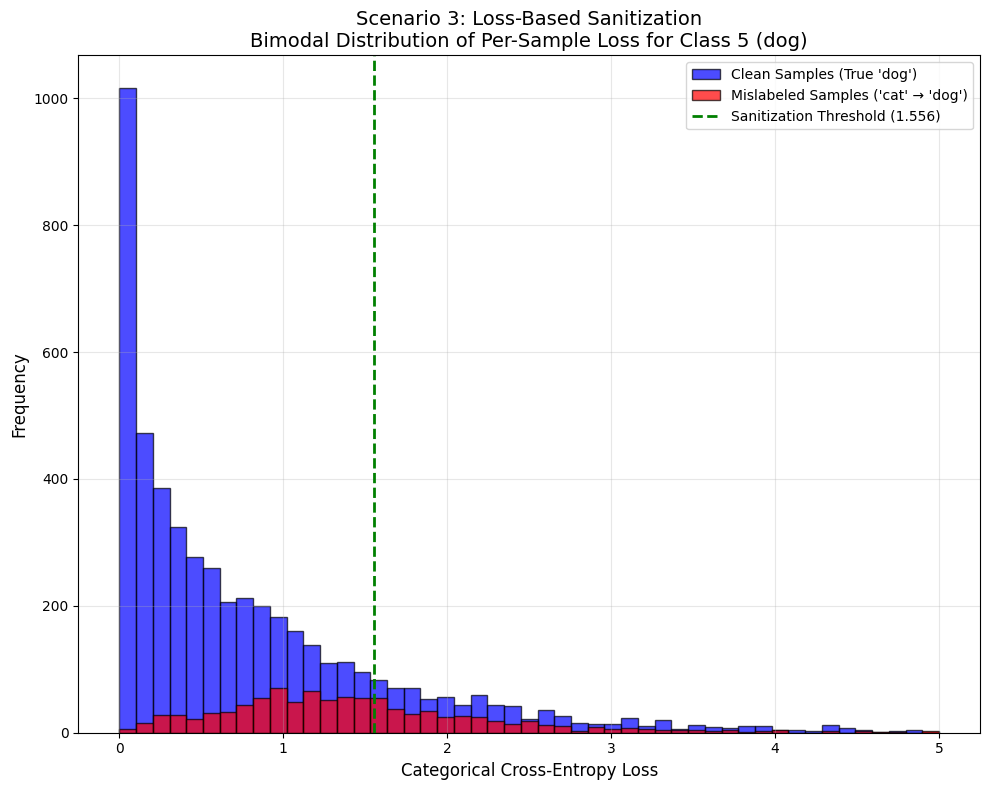

In [25]:
plt.figure(figsize=(10, 8))

# Separate losses
clean_losses = per_sample_loss[~is_flipped_target]
flipped_losses = per_sample_loss[is_flipped_target]

# Determine bin range
max_loss = max(np.max(clean_losses), np.max(flipped_losses))
bins = np.linspace(0, min(max_loss, 5), 50)

# Plot histograms
plt.hist(clean_losses, bins=bins, alpha=0.7,
         label=f"Clean Samples (True '{CLASS_NAMES[TARGET_CLASS]}')", color='blue', edgecolor='black')
plt.hist(flipped_losses, bins=bins, alpha=0.7,
         label=f"Mislabeled Samples ('{CLASS_NAMES[SOURCE_CLASS]}' → '{CLASS_NAMES[TARGET_CLASS]}')", color='red', edgecolor='black')

# Add threshold line
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
            label=f'Sanitization Threshold ({threshold:.3f})')

plt.xlabel('Categorical Cross-Entropy Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Scenario 3: Loss-Based Sanitization\nBimodal Distribution of Per-Sample Loss for Class {TARGET_CLASS} ({CLASS_NAMES[TARGET_CLASS]})', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 3.6: Retrain on Cleaned Data

In [26]:
# Remove high-loss samples
clean_mask = ~suspected_poison
x_clean = x_target[clean_mask]
y_clean = y_target[clean_mask]

# Combine with other classes
other_classes_mask = np.argmax(y_train_s3, axis=1) != TARGET_CLASS
x_train_cleaned = np.vstack([x_train_s3[other_classes_mask], x_clean])
y_train_cleaned = np.vstack([y_train_s3[other_classes_mask], y_clean])

print(f"Removed {len(x_target) - len(x_clean)} samples")

# Retrain
print("Retraining model on cleaned data...")
model_s3_clean = build_cnn_model()
model_s3_clean.fit(
    x_train_cleaned, y_train_cleaned,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=0
)

classifier_s3_clean = create_art_classifier(model_s3_clean)
print("Retraining complete!")

Removed 1200 samples
Retraining model on cleaned data...
Retraining complete!


### Step 3.7: Measure Attack Impact (After Defense)

In [27]:
predictions_after = np.argmax(classifier_s3_clean.predict(x_test[test_source_indices]), axis=1)
asr_s3_after = np.mean(predictions_after == TARGET_CLASS) * 100
correct_source_after = np.mean(predictions_after == SOURCE_CLASS) * 100

print("=" * 50)
print("SCENARIO 3 RESULTS: Label Flipping vs. Loss Sanitization")
print("=" * 50)
print(f"Misclassification (Before): {asr_s3_before:.2f}%")
print(f"Misclassification (After):  {asr_s3_after:.2f}%")
print(f"Correct '{CLASS_NAMES[SOURCE_CLASS]}' (Before): {correct_source:.2f}%")
print(f"Correct '{CLASS_NAMES[SOURCE_CLASS]}' (After):  {correct_source_after:.2f}%")
print(f"Improvement: {correct_source_after - correct_source:.2f}%")
print("=" * 50)

SCENARIO 3 RESULTS: Label Flipping vs. Loss Sanitization
Misclassification (Before): 41.50%
Misclassification (After):  0.00%
Correct 'cat' (Before): 28.00%
Correct 'cat' (After):  46.50%
Improvement: 18.50%


---

## Summary of Results

In [28]:
print("=" * 70)
print("FINAL SUMMARY: DIRTY LABEL DATA POISONING ATTACKS & DEFENSES (CIFAR-10)")
print("=" * 70)
print(f"Attack Target: '{CLASS_NAMES[SOURCE_CLASS]}' → '{CLASS_NAMES[TARGET_CLASS]}'")
print("-" * 70)
print(f"{'Scenario':<35} {'ASR Before':>12} {'ASR After':>12} {'Reduction':>12}")
print("-" * 70)
print(f"{'1. BadNets vs. Activation Clustering':<35} {asr_s1_before:>11.2f}% {asr_s1_after:>11.2f}% {asr_s1_before - asr_s1_after:>11.2f}%")
print(f"{'2. Blended vs. Spectral Signatures':<35} {asr_s2_before:>11.2f}% {asr_s2_after:>11.2f}% {asr_s2_before - asr_s2_after:>11.2f}%")
print(f"{'3. Label Flip vs. Loss Sanitization':<35} {asr_s3_before:>11.2f}% {asr_s3_after:>11.2f}% {asr_s3_before - asr_s3_after:>11.2f}%")
print("=" * 70)
print("\n✅ All defenses successfully reduced the Attack Success Rate!")

FINAL SUMMARY: DIRTY LABEL DATA POISONING ATTACKS & DEFENSES (CIFAR-10)
Attack Target: 'cat' → 'dog'
----------------------------------------------------------------------
Scenario                              ASR Before    ASR After    Reduction
----------------------------------------------------------------------
1. BadNets vs. Activation Clustering      100.00%        0.00%      100.00%
2. Blended vs. Spectral Signatures       100.00%        0.00%      100.00%
3. Label Flip vs. Loss Sanitization       41.50%        0.00%       41.50%

✅ All defenses successfully reduced the Attack Success Rate!
